**GENERATING SYNTHETIC MEDICAL TABULAR DATA**

**Author:**

 Maria Rodriguez

**SCENARIO**

Dr. AA is conducting a study to better understand a rare disease.  However, due to the rarity of the disease, he could not gather enough numbers that would power statistical analyses.

In an international conference, he met Dr. BB who was presenting case reports on the disease and who also acknowledged the difficulty of recruiting patients for enrollment in a study.

They agreed to collaborate.  However, their individual hospitals would not give them permission to share patient data due to privacy constraints.

What can they do so that they can do robust research on this challenging patient population while maintaining rigid privacy standards?

**Primary Objective:**

To generate a synthetic medical dataset for a patient population

**Secondary Objectives:**

1.  Demonstrate the transformation of human-interpretable categorical and continuous data to a tensor input, and the re-transformation of the tensor output to human-interpretable data
2.  Explore the use of tabular data (continuous and categorical variables) in deep learning generative models
3. Evaluate the performance of generative models regarding its ability to create synthetic data that closely approximates the real data:  
  *   Variational AutoEncoder
  *   Generative Adversarial Network




**OUTLINE**

A.  Data Loading and Preparation

B.  Create, Train and Evaluate VAE model

C.  Create, Train and Evaluate GAN model


In [18]:
# uncomment this at the start of the run, needed particularly for the mse loss

!pip install tensorflow==2.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 31.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      

**A.  DATA LOADING and PREPARATION**

-  Using medical patient data from https://synthetichealth.github.io/synthea/
1.  Get continuous  and categorical variables
2.   Merge continuous and categorical variables
3.    Split data to Train / Test sets
4.  Data Transformation


In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/UofT_DL_Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
def plotting(history, plot_title, plot_comment):
  plt.figure()
  plt.plot(history.history['loss'], label = 'train_LOSS')
  plt.plot(history.history['val_loss'], label = 'val_LOSS')

  plt.title('{} Model: {} '.format(plot_title, plot_comment))
  plt.ylabel('Loss')
  plt.xlabel('N_Epoch')
  plt.legend();

A.1.  Get categorical and continuous variables

In [3]:
# get categorical var: GENDER
cats = pd.read_csv(drive_path + '/patients.csv')
# cats.Id.nunique()  # 1171

cats = cats[['Id', 'GENDER']].set_index('Id')

In [4]:
# get continuous vars: SBP, DBP
obs = pd.read_csv(drive_path + '/observations.csv')
sbp = obs [ obs.DESCRIPTION == 'Systolic Blood Pressure']

# get the first SBP and DBP values per patient as representative
sbp_first = sbp.groupby(['PATIENT'])[['VALUE']].first()

dbp = obs [ obs.DESCRIPTION == 'Diastolic Blood Pressure']
dbp_first = dbp.groupby(['PATIENT'])[['VALUE']].first()

conts = pd.merge(sbp_first, dbp_first, left_index=True, right_index=True)
conts.columns = ['SBP', 'DBP']

A.2.  Merge categorical and continuous variables to a single tabular dataset

In [5]:
df = pd.concat([cats, conts], axis=1)
df.SBP = df.SBP.astype(float)
df.DBP = df.DBP.astype(float)

df.head(3)  # len(df) # 1171

,GENDER,SBP,DBP
1d604da9-9a81-4ba9-80c2-de3375d59b40,M,107.0,83.0
034e9e3b-2def-4559-bb2a-7850888ae060,M,119.0,82.0
10339b10-3cd1-4ac3-ac13-ec26728cb592,M,121.0,70.0


In [6]:
# df.isnull().sum()  # 0 nulls

A.3.  Split to Train / Test Sets.  

Note:  Use validation size during VAE training.  GAN does not need validation set

In [7]:
# stratify by gender
from sklearn.model_selection import train_test_split
train_, test = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df.GENDER)

## if decide to use a separate validation set, uncomment below:
# train, val = train_test_split(train_, test_size = 0.2, random_state = 42)

print(train_.shape)
print(test.shape)

(936, 3)
(235, 3)


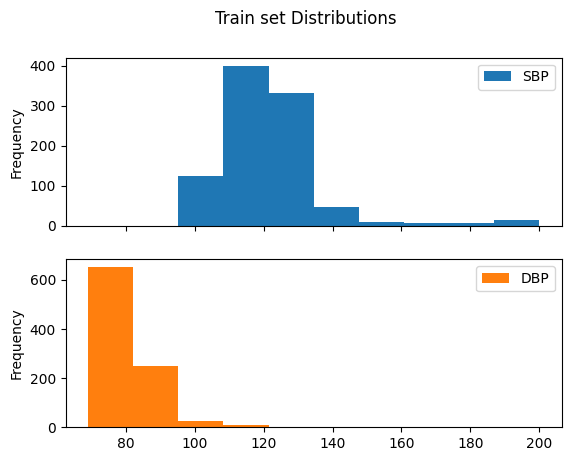

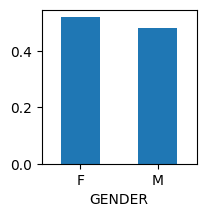

In [8]:
# vizualize distributions of train set
plt.figure
train_[['SBP','DBP']].plot(kind='hist', subplots=True)
plt.suptitle('Train set Distributions')
plt.figure()
train_.GENDER.value_counts(normalize=True).plot(kind='bar', rot=0, figsize = (2,2));

A.4  Data Transformation

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np

In [10]:
categoricals = df.select_dtypes(include=['object', 'category']).columns.tolist()
continuous = df.select_dtypes(include=['int', 'float']).columns.tolist()

In [11]:
# transform continuous variables
from sklearn.preprocessing import MinMaxScaler

def preprocess_continuous(train, test, var):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_[var])
    test_scaled = scaler.transform(test[ var ] )
    return train_scaled, test_scaled, scaler

In [12]:
# transform categorical variable
def preprocess_categorical(train, test, var, vocab):

    # create layers for one hot encoding
    cat_lookup = tf.keras.layers.StringLookup(vocabulary= vocab, num_oov_indices=0, output_mode='int')
    cat_one_hot = tf.keras.layers.CategoryEncoding(num_tokens= cat_lookup.vocabulary_size(), output_mode='one_hot')

    # run one-hot encoding layers
    def preprocess_cat(cat):
        cat_int = cat_lookup(cat)
        cat_one_hot_encoded = cat_one_hot(cat_int)
        return cat_one_hot_encoded

    # using tensorflow's Dataset function for data flow, convert values to tensors then perform one-hot encoding
    def encode_cat(df):
        cat_dataset = tf.data.Dataset.from_tensor_slices(df[var].values)
        encoded_cat_dataset = cat_dataset.map(preprocess_cat)
        encoded_cat_list = [item.numpy().tolist() for item in encoded_cat_dataset]
        return encoded_cat_list

    # run functions defined above to encode categorical data
    train_cat_proc = encode_cat(train)
    test_cat_proc = encode_cat(test)

    # convert to numpy arrays to facilitate data concatenation later
    return np.array(train_cat_proc), np.array(test_cat_proc)

In [13]:
# run the transformation functions previous defined
train_cont, test_cont, scaler = preprocess_continuous(train_, test, continuous)

train_cat_gender, test_cat_gender = preprocess_categorical(train_, test, 'GENDER', cats.GENDER.unique()  )
# reshape categorical array to facilitate stacking with continuous variables
train_cat = train_cat_gender.reshape(936, 2)
test_cat = test_cat_gender.reshape(235, 2)

# stack the continuous and categorical transformed data to a single processed train and test sets
train_proc = np.hstack((train_cont, train_cat))
test_proc = np.hstack((test_cont, test_cat))

In [14]:
# Display data transformed into tensors
print('Tensor samples')
print(train_proc[0:5])
print('Tensor shape')
print(train_proc.shape)

Tensor samples
[[0.12871287 0.20408163 0.         1.        ]
 [0.13861386 0.14285714 1.         0.        ]
 [0.24752475 0.26530612 0.         1.        ]
 [0.1980198  0.26530612 1.         0.        ]
 [0.28712871 0.2244898  0.         1.        ]]
Tensor shape
(936, 4)


**B.  CREATE AND TRAIN VARIATIONAL AUTOENCODER MODEL**

1.  Define sampling batch
2.  Create Encoder
3.  Create Decoder
4.  Define losses
5.  Compile and train
6.  Visualize results
7.  Evaluate model on Test set

B.1.  Define Sampling Batch

In [15]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = K.shape(mean)[0]
        dim = K.int_shape(mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return mean + K.exp(0.5 * log_var) * epsilon

B.2 to 6.  Create Encoder and Decoder, Define Losses, Train, Evaluate on Test set

Epoch 1/40
6/6 [==============================] - 4s 65ms/step - loss: 3.4387 - val_loss: 0.8802
Epoch 2/40
6/6 [==============================] - 0s 14ms/step - loss: 2.2113 - val_loss: 0.7829
Epoch 3/40
6/6 [==============================] - 0s 14ms/step - loss: 1.8646 - val_loss: 0.6956
Epoch 4/40
6/6 [==============================] - 0s 13ms/step - loss: 1.5960 - val_loss: 0.6504
Epoch 5/40
6/6 [==============================] - 0s 16ms/step - loss: 1.3467 - val_loss: 0.6130
Epoch 6/40
6/6 [==============================] - 0s 13ms/step - loss: 1.2387 - val_loss: 0.5870
Epoch 7/40
6/6 [==============================] - 0s 17ms/step - loss: 1.1358 - val_loss: 0.5873
Epoch 8/40
6/6 [==============================] - 0s 17ms/step - loss: 1.0703 - val_loss: 0.5766
Epoch 9/40
6/6 [==============================] - 0s 17ms/step - loss: 1.0180 - val_loss: 0.5753
Epoch 10/40
6/6 [==============================] - 0s 16ms/step - loss: 0.8992 - val_loss: 0.5726
Epoch 11/40
6/6 [============

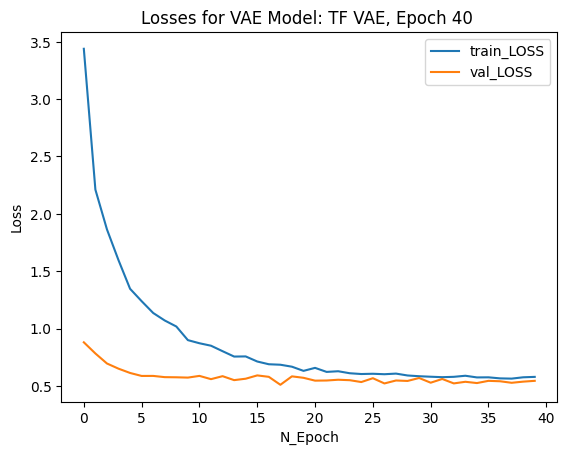

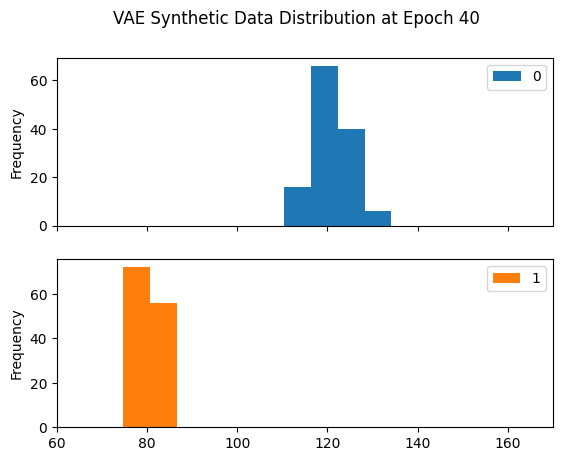

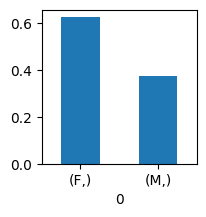

In [16]:
# VAE training code
# epoch_list = [20, 50, 100], 200, 500]
epoch_list = [40]
codings_size = 10    # dimensionality of latent vectors
batch_size = 128
epsilon = np.random.normal(size=(batch_size, codings_size))

for epoch in epoch_list:
    # ENCODER
    inputs = keras.layers.Input(shape= (train_proc.shape[1], ))
    z = keras.layers.Dense(100, activation="selu")(inputs)
    z = keras.layers.Dense(100, activation="selu")(z)
    z = keras.layers.Dropout(0.5)(z)

    # Define the latent variables mean and var, using the batch sampling
    codings_mean = keras.layers.Dense(codings_size)(z)
    codings_log_var = keras.layers.Dense(codings_size)(z)
    codings = Sampling()([codings_mean, codings_log_var])

    # Defne the encoder part of the model
    # Outputs include the computed mean and variation for the population
    variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

    # DECODER
    decoder_inputs = keras.layers.Input(shape=[codings_size])
    x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
    x = keras.layers.Dense(100, activation="selu")(x)
    x = keras.layers.Dropout(0.5)(x)
    # separate the outputs for the categorical and continuous variables
    #    with the appropriate activation functions
    cont_output = keras.layers.Dense(train_cont.shape[1], activation="linear")(x)
    cat_output = keras.layers.Dense(train_cat.shape[1], activation="softmax")(x)
    # once processed separately, concatenate the results
    outputs = keras.layers.concatenate([cont_output, cat_output])

    # Define the decoder part of the model
    variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

    # Decoder to use the codings output by the Encoder
    codings_mean, codings_log_var, codings = variational_encoder(inputs)  # Get intermediate outputs
    reconstructions = variational_decoder(codings)

    # Define the combined Encoder-Decoder model
    variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions, codings_mean, codings_log_var])  # Include intermediate outputs in the final model

    # Define the loss functions
    reconstruction_loss = keras.losses.mean_squared_error(inputs, reconstructions) # need specific tf version
    reconstruction_loss *= train_proc.shape[1]
    kl_loss = 1 + codings_log_var - K.square(codings_mean) - K.exp(codings_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    variational_ae.add_loss(vae_loss)

    # Compile the VAE model
    variational_ae.compile(optimizer="adam")

    # Define callbacks for optional use
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,  # Number of epochs with no improvement to stop training
        restore_best_weights=True
    )

    model_checkpoint = keras.callbacks.ModelCheckpoint(
        drive_path + '/models/vae_model_epoch_{}.h5'.format([epoch]),
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )

    history = variational_ae.fit(
        train_proc,
        epochs=epoch,
        batch_size=batch_size,
        validation_split=0.2,  # important, coz no separate validation set
        # callbacks=[early_stopping, model_checkpoint]   ## uncomment as needed
    )

    # Plot training
    plotting(history, 'Losses for VAE', 'TF VAE, Epoch {}'.format(epoch))

    # Generate synthetic data using noise
    syn_data = variational_decoder.predict(epsilon)

    # Re-transform the synthetic data back to a human-interpretable format
    syn_continuous = scaler.inverse_transform(syn_data[:, :train_cont.shape[1]])
    syn_categorical = np.argmax(syn_data[:, train_cat.shape[1]:], axis=-1)

    # Visualize the synthetic data to gauge training results
    pd.DataFrame(syn_continuous).plot(kind='hist', subplots= True, )
    plt.suptitle('VAE Synthetic Data Distribution at Epoch {}'.format(epoch) ) ;
    plt.xlim(60,170)

    syn_categorical_indices = np.argmax(syn_data[:, train_cont.shape[1]:], axis=-1)
    categories = ['M', 'F']
    decoded_categories = [categories[idx] for idx in syn_categorical_indices]
    plt.figure()
    pd.DataFrame(decoded_categories).value_counts(normalize=True).plot(kind='bar', rot=0, figsize = (2,2) )

B.7.  Evaluate VAE model on Test set

In [19]:
# load saved VAE model
# vae_model_path = drive_path + '/models/vae_model_epoch_[50].h5'
# variational_ae_loaded = keras.models.load_model(vae_model_path, custom_objects={'Sampling': Sampling})

8/8 [==============================] - 0s 2ms/step


,SBP,DBP,GENDER
0,121.869209,81.370529,F
1,121.222267,80.260506,F
2,122.159088,79.773735,M
3,121.774261,79.691544,M
4,123.694298,78.880646,F


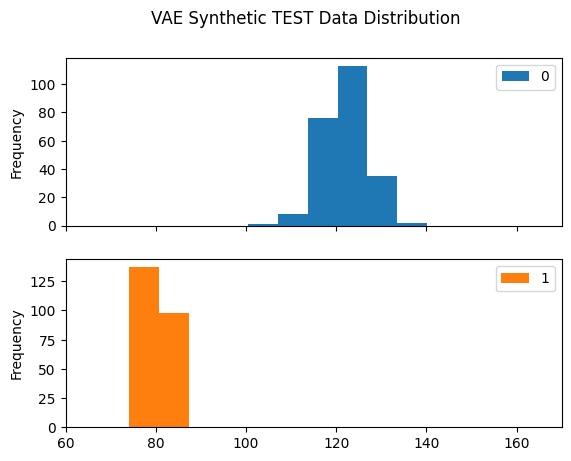

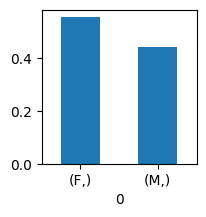

In [20]:
codings_size = 10
batch_size = 128
# noise from the test set
epsilon = np.random.normal(size=(test_proc.shape[0], codings_size))

# Use the decoder part of the VAE model to generate continuous synthetic data from the test set
# syn_data_test = variational_ae.layers[-1](epsilon).numpy()
syn_data_test = variational_decoder.predict(epsilon)

# Inverse transform to a humna-interpretable format
syn_continuous_test = scaler.inverse_transform(syn_data_test[:, :test_cont.shape[1]])
syn_categorical_test = np.argmax(syn_data_test[:, test_cat.shape[1]:], axis=-1)

# Visualize the synthetic data to gauge training results
pd.DataFrame(syn_continuous_test).plot(kind='hist', subplots= True, )
plt.suptitle('VAE Synthetic TEST Data Distribution'.format(epoch) ) ;
plt.xlim(60,170)

syn_categorical_indices_test = np.argmax(syn_data_test[:, test_cont.shape[1]:], axis=-1)
categories = ['M', 'F']
decoded_categories = [categories[idx] for idx in syn_categorical_indices_test]
plt.figure()
pd.DataFrame(decoded_categories).value_counts(normalize=True).plot(kind='bar', rot=0, figsize = (2,2) )

# Generate synthetic dataset table
synthetic_data_df_vae = pd.concat( [ pd.DataFrame(syn_continuous_test), pd.DataFrame(decoded_categories )] , axis=1)
synthetic_data_df_vae.columns = ['SBP', 'DBP', 'GENDER']
display(synthetic_data_df_vae.head())

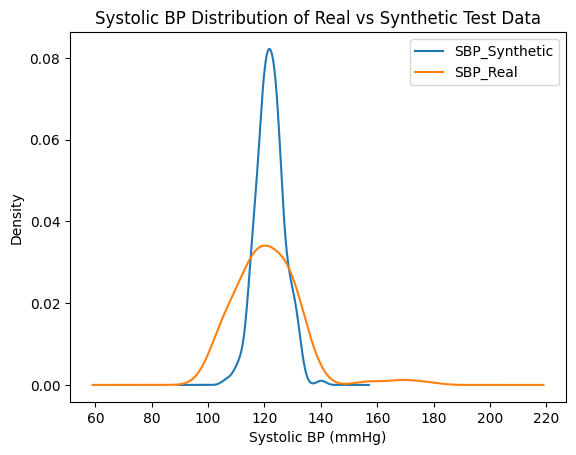

In [56]:
sbp = pd.concat([synthetic_data_df_vae.SBP, test.SBP], axis=1)
sbp.columns = ['SBP_Synthetic', 'SBP_Real']
sbp.plot(kind='kde')
plt.xlabel('Systolic BP (mmHg)')
plt.title('Systolic BP Distribution of Real vs Synthetic Test Data');

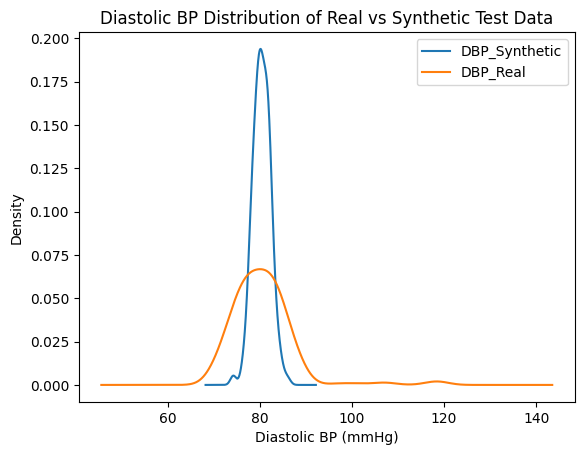

In [57]:
dbp = pd.concat([synthetic_data_df_vae.DBP, test.DBP], axis=1)
dbp.columns = ['DBP_Synthetic', 'DBP_Real']
dbp.plot(kind='kde');
plt.xlabel('Diastolic BP (mmHg)')
plt.title('Diastolic BP Distribution of Real vs Synthetic Test Data');

In [42]:
gend = pd.concat([synthetic_data_df_vae.GENDER, test.GENDER.reset_index()], axis=1).drop('index', axis=1)
gend.columns = ['GENDER_Synthetic', 'GENDER_Real']
len( gend [ gend.GENDER_Real == gend.GENDER_Synthetic]) / len(gend)

0.4595744680851064

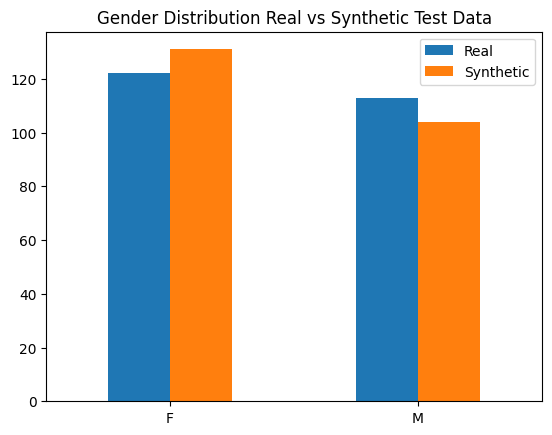

In [52]:
gen_real_ct = gend.GENDER_Real.value_counts()
gen_syn_ct = gend.GENDER_Synthetic.value_counts()
gen_ct = pd.concat([gen_real_ct, gen_syn_ct], axis=1)
gen_ct.columns = ['Real', 'Synthetic']
gen_ct.plot(kind='bar', rot= 0)
plt.title('Gender Distribution Real vs Synthetic Test Data');

**RESULTS**:

The VAE model with 2 hidden layers (of 100 nodes each), with Dropout layers, using a latent variable size of 10 on a tabular Train dataset with 936 rows, 2 continuous variables and 1 categorical variable reached convergence before 40 epochs.

The synthetic data generated on the Test set showed an equivalent distribution to the actual Test set, showing that the **model fit was good and is able to generalize to new data**.

This shows that **VAE can be applied to generate synthetic tabular data containing both continuous and categorical variables**.

**C.  CREATE AND TRAIN A GENERATIVE ADVERSARIAL NETWORK MODEL**

1.  Create Generator
2.  Create Discriminator
3.  Define Losses
4.  Compile and train
5.  Visualize results
5.  Evaluate model on Test set

C.1 to 5  Create Generator, Disciminator, Compile and Train GAN

30/30 [==============================] - 0s 2ms/step


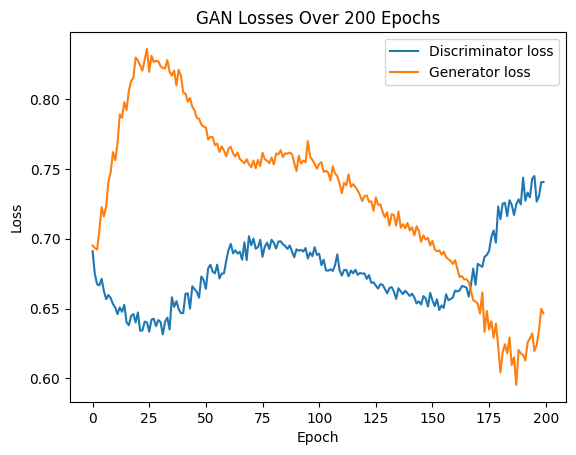

<Figure size 640x480 with 0 Axes>

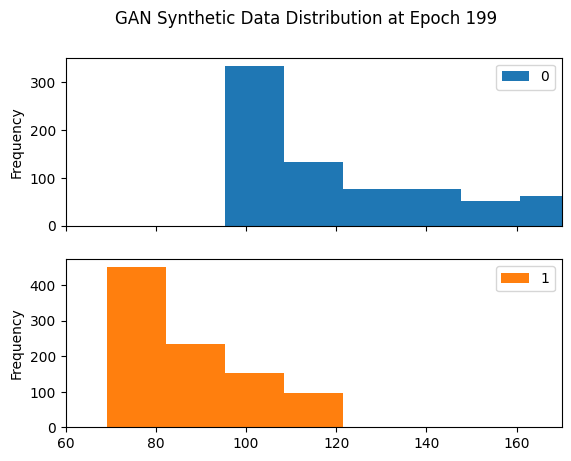

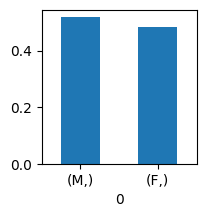

In [74]:
# GAN training code
# epoch_list = [20, 50, 100, 200,]# 500]
epoch_list = [200]
batch_size = 128
codings_size = 10  # Dimensionality of latent vectors

for epochs in epoch_list:
    # GENERATOR
    # to be fed random noise (code below) , and will output data with the same shape as the given data
    generator = keras.models.Sequential([
        # use selu to stabilize output by normalization
        keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
        # use sigmoid to for normalized output for continuous variables
        #      and probabilities for the binary categorical variable
        keras.layers.Dense(train_cont.shape[1] + train_cat.shape[1], activation="sigmoid"),
    ])

    # DISCRIMINATOR
    # to determine real vs fake data (code below)
    discriminator = keras.models.Sequential([
        keras.layers.Dense(150, activation="selu", input_shape=[train_cont.shape[1] + train_cat.shape[1]]),
        # use sigmoid for real vs fake
        keras.layers.Dense(1, activation="sigmoid"),
    ])

    # GAN MODEL and define LOSS FUNCTIONS
    gan = keras.models.Sequential([generator, discriminator])

    # use binary crossentropy loss function, in accordance with the sigmoid activation functions above
    # Generator and Discriminator trained separately
    generator.compile(loss="binary_crossentropy", optimizer="adam")
    # Discriminator weights are updated to minimize binary crossentry loss
    discriminator.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    # Do not update Discriminator weights while Generator is being trained
    discriminator.trainable = False
    gan.compile(loss='binary_crossentropy', optimizer="adam")

    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        # Prepare REAL data
        idx = np.random.randint(0, train_proc.shape[0], batch_size)
        real_data = train_proc[idx]

        # Generate FAKE data using noise
        noise = np.random.normal(0, 1, (batch_size, codings_size))
        generated_data = generator.predict(noise)

        # Train Discriminator
        #    on REAL data  (1's)
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
        #    on FAKE data  (0's)
        d_loss_fake = discriminator.train_on_batch(generated_data, np.zeros((batch_size, 1)))
        # Combined discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator (with Discriminator frozen)
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, codings_size))
        # use GAN model to train generator, use 1's to mask fake data
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

    # Visualize generator and discriminator losses during training
    plt.figure()
    plt.plot(d_losses, label='Discriminator loss')
    plt.plot(g_losses, label='Generator loss')
    plt.title('GAN Losses Over {} Epochs'.format(epochs))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Generate synthetic data using noise from the train set
    num_samples = train_.shape[0]
    noise = np.random.normal(0, 1, (num_samples, codings_size))
    synthetic_data = generator.predict(noise)

    # Inverse transform continuous data to human-translatable format
    synthetic_data_continuous = synthetic_data[:, :train_cont.shape[1]]
    synthetic_data_categorical = synthetic_data[:, train_cont.shape[1]:]

    synthetic_data_continuous_inv_tr = scaler.inverse_transform(synthetic_data_continuous)

    # Visualize synthetic data distribution
    plt.figure()
    pd.DataFrame(synthetic_data_continuous_inv_tr).plot(kind='hist', subplots=True)
    plt.suptitle('GAN Synthetic Data Distribution at Epoch {}'.format(epoch) ) ;
    plt.xlim(60, 170)

    decoded_categorical_indices = np.argmax(synthetic_data_categorical, axis=-1)
    categories = ['M', 'F']
    decoded_categories = [categories[idx] for idx in decoded_categorical_indices]

    plt.figure()
    pd.DataFrame(decoded_categories).value_counts(normalize=True).plot(kind='bar', rot=0, figsize=(2, 2))

C.7  Evaluate GAN model on Test set

8/8 [==============================] - 0s 2ms/step


,SBP,DBP,GENDER
0,145.889282,104.193130,M
1,99.448532,70.754463,F
2,105.207321,75.398659,F
3,101.573242,76.653130,F
4,198.807724,116.497116,M


<Figure size 640x480 with 0 Axes>

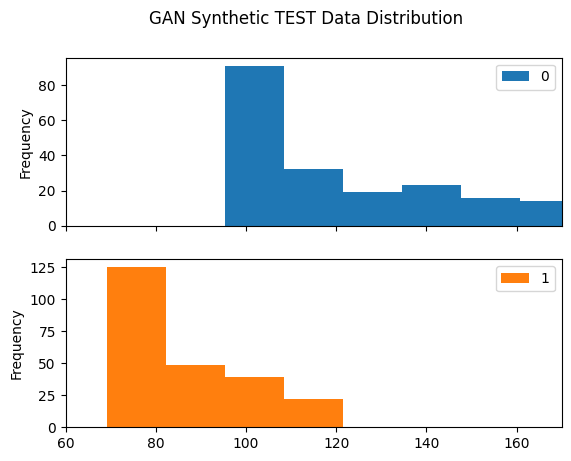

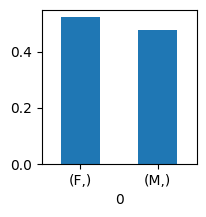

In [75]:
# Generate synthetic data using noise from the TEST set
num_samples_test = test.shape[0]
noise_test = np.random.normal(0, 1, (num_samples_test, codings_size))
synthetic_data_test = generator.predict(noise_test)

# Inverse transform continuous data to human-translatable format
synthetic_data_continuous_test = synthetic_data_test[:, :train_cont.shape[1]]
synthetic_data_categorical_test = synthetic_data_test[:, train_cont.shape[1]:]

synthetic_data_continuous_inv_tr_test = scaler.inverse_transform(synthetic_data_continuous_test)

# Visualize synthetic data distribution
plt.figure()
pd.DataFrame(synthetic_data_continuous_inv_tr_test).plot(kind='hist', subplots=True)
plt.suptitle('GAN Synthetic TEST Data Distribution'.format(epoch) ) ;
plt.xlim(60, 170)

decoded_categorical_indices = np.argmax(synthetic_data_categorical_test, axis=-1)
categories = ['M', 'F']
decoded_categories = [categories[idx] for idx in decoded_categorical_indices]

plt.figure()
pd.DataFrame(decoded_categories).value_counts(normalize=True).plot(kind='bar', rot=0, figsize=(2, 2))

# Create the synthetic dataset that is human-interpretable
synthetic_data_df_gan = pd.concat( [ pd.DataFrame(synthetic_data_continuous_inv_tr_test), pd.DataFrame(decoded_categories )] , axis=1)
synthetic_data_df_gan.columns = ['SBP', 'DBP', 'GENDER']
display(synthetic_data_df_gan.head())

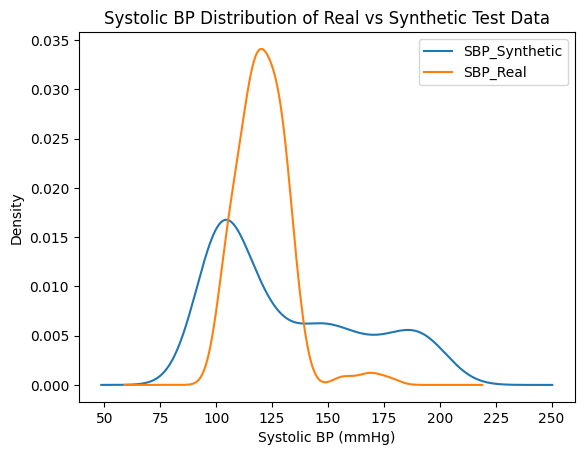

In [76]:
sbp = pd.concat([synthetic_data_df_gan.SBP, test.SBP], axis=1)
sbp.columns = ['SBP_Synthetic', 'SBP_Real']
sbp.plot(kind='kde')
plt.xlabel('Systolic BP (mmHg)')
plt.title('Systolic BP Distribution of Real vs Synthetic Test Data');

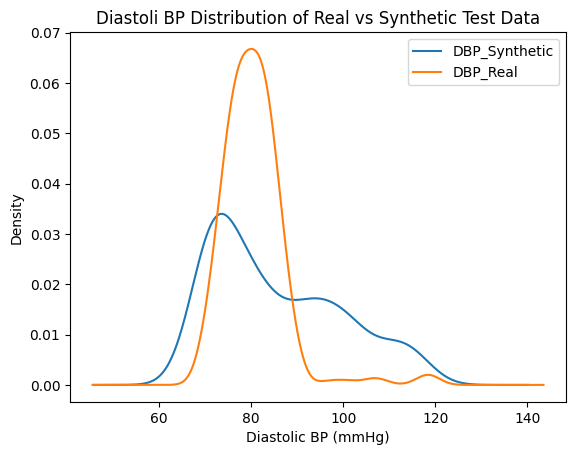

In [77]:
dbp = pd.concat([synthetic_data_df_gan.DBP, test.DBP], axis=1)
dbp.columns = ['DBP_Synthetic', 'DBP_Real']
dbp.plot(kind='kde')
plt.xlabel('Diastolic BP (mmHg)')
plt.title('Diastoli BP Distribution of Real vs Synthetic Test Data');

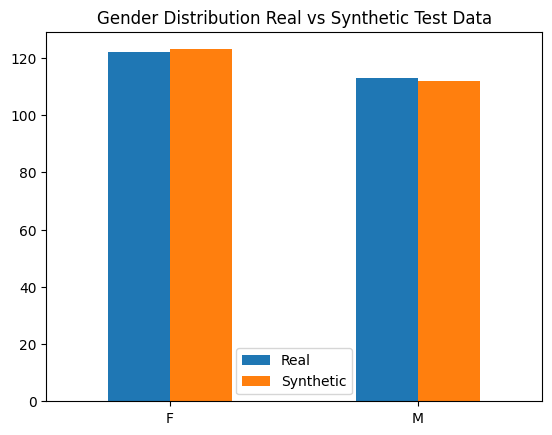

In [78]:
gend = pd.concat([synthetic_data_df_gan.GENDER, test.GENDER.reset_index()], axis=1).drop('index', axis=1)
gend.columns = ['GENDER_Synthetic', 'GENDER_Real']
len( gend [ gend.GENDER_Real == gend.GENDER_Synthetic]) / len(gend)

gen_real_ct = gend.GENDER_Real.value_counts()
gen_syn_ct = gend.GENDER_Synthetic.value_counts()
gen_ct = pd.concat([gen_real_ct, gen_syn_ct], axis=1)
gen_ct.columns = ['Real', 'Synthetic']
gen_ct.plot(kind='bar', rot= 0)
plt.title('Gender Distribution Real vs Synthetic Test Data');

**RESULTS**:

 The GAN model used a single hidden layer (with 100 nodes for the generator and 150 nodes for the discriminator), and 10 latent variable size.  The model **training showed a torsade pattern illustrating the adversarial method** between the training of the generative and discriminator components.  It can be considered that 'convergence' was reached at around Epoch 100 - 200.

The **synthetic data generated from the Test set showed a distribution nearly equivalent with the Real Test set**.  (Note: the distribution was more equivalent at lesser Epochs, but a higher Epoch was used here to demonstrate the adversarial training).  This shows the the **model training was reasonable and is able to generalize to new data**.

This shows that **GAN can be applied to generate synthetic tabular data containing both continuous and categorical variables**.

**COMPARING RESULTS BETWEEN VAE AND GAN:**

**VAE reached convergence faster.  Both VAE and GAN and had similar distributions between real and synthetic data** with this small dataset.  

Due to the continuous improvement in training, it can be hypothesized that GAN may be more useful for more complex and bigger datasets.

**TECHNICAL CONCLUSION:**

VAE and GAN generative models can generate reasonable synthetic tabular data containing heterogenous variables.  



**REAL-WORLD APPLICATION:**

This will be useful in medical research to alleviate privacy restrictions.  It will enable data sharing between different institutions which will lead to data that is more representative of the whole population, particularly for rare diseases.

*Acknowledgment:* ChatGPT and Gemini were used to help elaborate the models and fix bugs.